# Gounot dataset of bacteria from glaciers

In [1]:
import numpy as np
import pandas as pd
import random

random.seed(42)

from matplotlib import pyplot as plt

from scipy.optimize import minimize
from sklearn.model_selection import LeaveOneOut

In [2]:
def briere1(T, Tmin=10.0, Tmax=50.0, c=1.0):
    result = np.zeros(len(T))
    cond = (Tmin < T) & (T < Tmax)
    result[cond] = c * T[cond] * np.exp(np.log(T[cond] - Tmin) + 0.5 * np.log(Tmax - T[cond]))
    return result

def briere2(T, Tmin=10.0, Tmax=50.0, c=1.0, b=2.0):
    result = np.zeros(len(T))
    cond = (Tmin < T) & (T < Tmax)
    result[cond] = c * T[cond] * np.exp(np.log(T[cond] - Tmin) +  np.log(Tmax - T[cond]) / b)
    return result

# Fully biologically interpretable parametrization of flexTPC model
def flexTPC(T, Tmin=10.0, Tmax=50.0, rmax=1.0, α=0.8, β=0.2):
    result = np.zeros(len(T))
    cond = (Tmin < T) & (T < Tmax)
    s = α * (1.0 - α) / β**2
    result[cond] = rmax * np.exp(s * (α * (np.log(T[cond] - Tmin) - np.log(α)) +
                                      (1 - α) * (np.log(Tmax - T[cond]) - np.log(1 - α) )
                                       - np.log(Tmax - Tmin)))
    return result

In [3]:
glacierbac = pd.read_csv("glacierbac.csv")
glacierbac

,Unnamed: 0,species,strain,X,Y,psychro,T,r
0,0,Arthrobacter glacialis,137,3.457467,3.761369,True,16.0,0.043007
1,1,Arthrobacter glacialis,137,3.482460,3.985740,True,14.0,0.053825
2,2,Arthrobacter glacialis,137,3.501018,3.973215,True,12.0,0.053155
3,3,Arthrobacter glacialis,137,3.527881,3.858413,True,10.0,0.047390
4,4,Arthrobacter glacialis,137,3.565603,3.596571,True,7.0,0.036473
5,5,Arthrobacter glacialis,137,3.603963,3.328340,True,4.0,0.027892
6,6,Arthrobacter glacialis,137,3.655096,2.874697,True,0.0,0.017720
7,7,Arthrobacter glacialis,158,3.408169,3.639039,True,20.0,0.038055
8,8,Arthrobacter glacialis,158,3.431886,3.888990,True,18.0,0.048862
9,9,Arthrobacter glacialis,158,3.457496,3.959770,True,16.0,0.052445


## Fitting temperature response curves to model

In [4]:
def nloglik(θ, Tdata, rdata, model=flexTPC):
    params, σ2 = θ[:-1], θ[-1]
    Tmin, Tmax = θ[:2]
    outside = (Tdata < Tmin) | (Tdata > Tmax)
    inside = ~outside
    n = len(rdata[inside])
    if np.any(rdata[outside] > 0.0):
        return np.inf
    else:
        return 0.5 * (n * np.log(2*np.pi*σ2) + np.sum((rdata[inside] - model(Tdata[inside], *params))**2 / σ2))
    
def AIC(nll, p):
    return 2 * nll + 2 * p 

def BIC(nll, n, p):
    return 2 * nll + p * np.log(n)

In [5]:
strains = [55, 60, 76, 137, 158]

initial_b1 = {55:[-5.0, 35.0, 0.0002, 0.01],
              60:[-5.0, 35.0, 0.0002, 0.01],
              76:[-5.0, 35.0, 0.0003, 0.01],
             137:[-5.0, 22.0, 0.00008, 0.01],
             158:[-5.0, 22.0, 0.00008, 0.01]}

initial_b2 = {55:[-5.0, 35.0, 0.0002, 2.0, 0.01],
              60:[-5.0, 35.0, 0.0002, 2.0, 0.01],
              76:[-5.0, 35.0, 0.0003, 2.0, 0.01],
             137:[-5.0, 22.0, 0.00008, 2.0, 0.01],
             158:[-5.0, 22.0, 0.00008, 2.0, 0.01]}

initial_flex = {55:[-5.0, 35.0, 0.4, 0.8, 0.2, 0.01],
              60:[-5.0, 35.0, 0.4, 0.8, 0.2, 0.01],
              76:[-5.0, 35.0, 0.6, 0.8, 0.2, 0.01],
             137:[-5.0, 22.0, 0.05, 0.8, 0.2, 0.01],
             158:[-5.0, 22.0, 0.05, 0.8, 0.2, 0.01]}


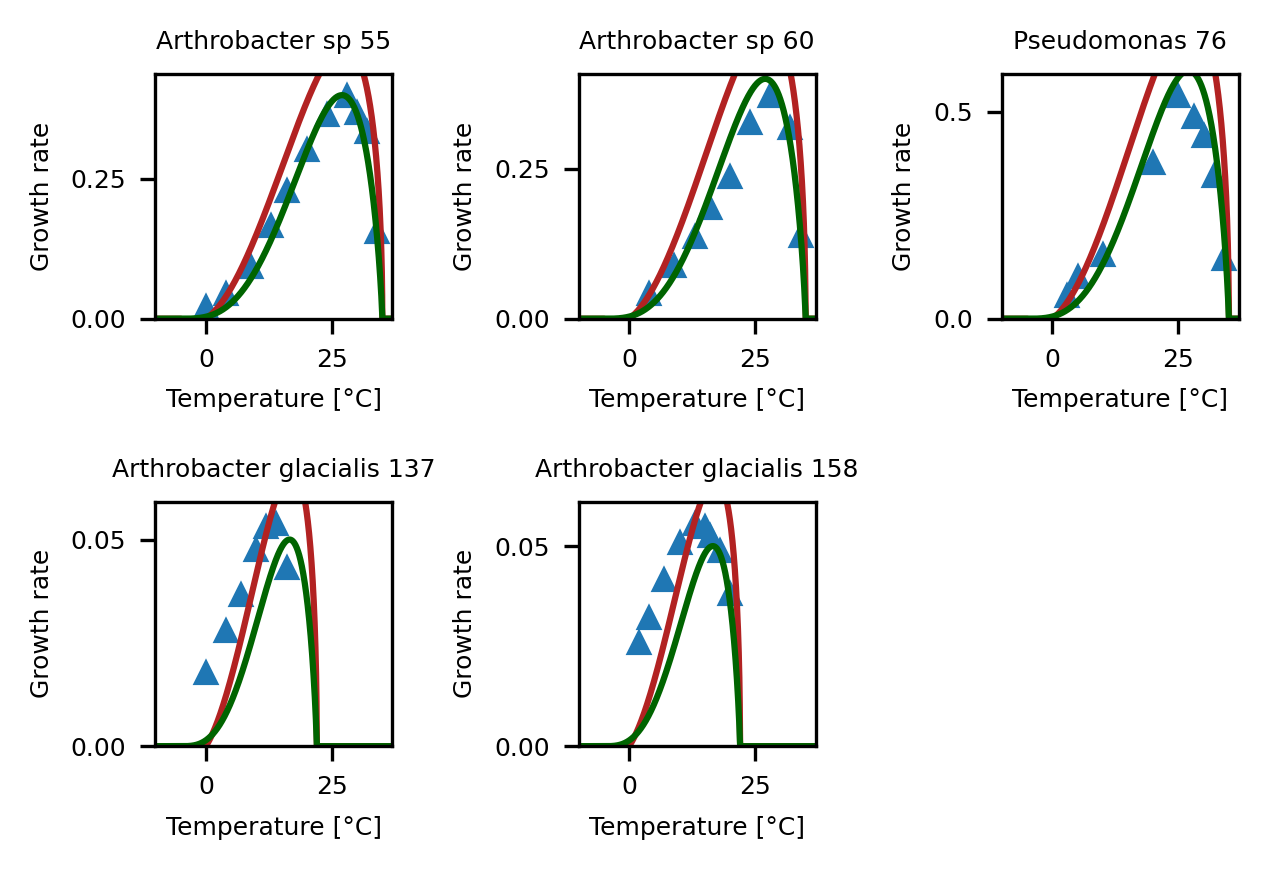

In [6]:
# Check initial value curves.
T = np.arange(-10, 40, 0.001)

plt.figure(figsize=(4.33, 3), dpi=300)

for i, s in enumerate(strains):
    subset = glacierbac[glacierbac["strain"] == s]
    species = list(subset["species"])[0]
    
    plt.subplot(2, 3, i+1)
    # Plot datapoints.
    Tdata = subset["T"]
    rdata = subset["r"]

    plt.plot(Tdata, rdata, '^', markersize=5)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.xlim(-10, 37)
    plt.ylim(0, max(rdata)*1.1)
    
    # Plot fitted curves by Briere.
    #params = params_b1[s]["x"]
    #plt.plot(T, briere1(T, *params[:-1]), color="firebrick")
    plt.plot(T, briere1(T, *initial_b1[s][:-1]), color="firebrick")
             
    #params = params_eb[s]["x"]
    #plt.plot(T, extbriere(T, *params[:-1]), color="steelblue")
    plt.plot(T, flexTPC(T, *initial_flex[s][:-1]), color="darkgreen")

    #plt.ylim(-0.025, 0.425)
    plt.xlabel("Temperature [°C]", fontsize=6)
    plt.ylabel("Growth rate", fontsize=6)
    

    
    plt.title(species + " " + str(s), fontsize=6)
plt.tight_layout()

In [8]:
# LOOCV.
loo = LeaveOneOut()

params = {"flexTPC":{}, "b1":{}, "b2":{}}
models = ["b1", "b2", "flexTPC"]
method = "Nelder-Mead"
loocv_nll = {model:{strain:[] for strain in strains } for model in models}

for i, s in enumerate(strains):
    subset = glacierbac[glacierbac["strain"] == s]
    Tdata = np.array(subset["T"])
    rdata = np.array(subset["r"])
    loo.get_n_splits(glacierbac["T"][glacierbac["strain"] == s])
        
    for train, test in loo.split(Tdata):
        T_train, r_train = Tdata[train], rdata[train]
        T_test, r_test = Tdata[test], rdata[test]
        
        params["b1"][s] = minimize(nloglik, initial_b1[s],
                                   bounds=[(-20.0, 20.0), 
                                           (10.0, 50.0), 
                                           (0.0, 1.0),  
                                           (0, 1.0)],
                          args=(T_train, r_train, briere1), options={"maxiter":10000}, method=method)
        θ = params["b1"][s]["x"]
        loocv_nll["b1"][s].append(nloglik(θ, T_test, r_test, model=briere1))
        
        params["b2"][s] = minimize(nloglik, initial_b2[s],
                                   bounds=[(-20.0, 20.0), 
                                           (10.0, 50.0), 
                                           (0.0, 1.0),
                                           (0.0, 20.0),
                                           (0, 1.0)],
                          args=(Tdata, rdata, briere2), options={"maxiter":10000}, method=method)
        θ = params["b2"][s]["x"]
        loocv_nll["b2"][s].append(nloglik(θ, T_test, r_test, model=briere2))     
        
        params["flexTPC"][s] = minimize(nloglik, initial_flex[s],
                                        bounds=[(-20.0, 20.0), 
                                               (10.0, 50.0), 
                                               (0.0, 1.0),
                                               (0.0, 1.0),
                                               (0.0, np.inf),
                                               (0, 1.0)],
                          args=(Tdata, rdata, flexTPC), options={"maxiter":10000}, method=method)
        θ = params["flexTPC"][s]["x"]
        loocv_nll["flexTPC"][s].append(nloglik(θ, T_test, r_test, model=flexTPC))

/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_14016/2868019315.py:10: RuntimeWarning: divide by zero encountered in log
  return 0.5 * (n * np.log(2*np.pi*σ2) + np.sum((rdata[inside] - model(Tdata[inside], *params))**2 / σ2))
/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_14016/2868019315.py:10: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (n * np.log(2*np.pi*σ2) + np.sum((rdata[inside] - model(Tdata[inside], *params))**2 / σ2))
/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_14016/2868019315.py:10: RuntimeWarning: invalid value encountered in scalar add
  return 0.5 * (n * np.log(2*np.pi*σ2) + np.sum((rdata[inside] - model(Tdata[inside], *params))**2 / σ2))


In [ ]:
?minimize

In [14]:
# Fit to whole datasets.

params = {"b1":{}, "b2":{}, "flexTPC":{}}
models = ["b1", "b2", "flexTPC"]
method = "Nelder-Mead"
for i, s in enumerate(strains):
    subset = glacierbac[glacierbac["strain"] == s]
    Tdata = np.array(subset["T"])
    rdata = np.array(subset["r"])    
    

    params["b1"][s] = minimize(nloglik, initial_b1[s],
                               bounds=[(-20.0, 20.0), 
                                           (10.0, 50.0), 
                                           (0.0, 1.0),  
                                           (0, 1.0)],
                      args=(Tdata, rdata, briere1), options={"maxiter":100000}, method=method)
    params["b2"][s] = minimize(nloglik, initial_b2[s],
                               bounds=[(-20.0, 20.0), 
                                           (10.0, 50.0), 
                                           (0.0, 1.0),
                                           (0.0, 20.0),
                                           (0, 1.0)],
                      args=(Tdata, rdata, briere2), options={"maxiter":100000}, method=method)
    params["flexTPC"][s] = minimize(nloglik, initial_flex[s],
                                    bounds=[(-20.0, 20.0), 
                                               (10.0, 50.0), 
                                               (0.0, 1.0),
                                               (0.0, 1.0),
                                               (0.0, np.inf),
                                               (0, 1.0)],
                      args=(Tdata, rdata), options={"maxiter":100000}, method=method)

/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_14016/2868019315.py:10: RuntimeWarning: divide by zero encountered in log
  return 0.5 * (n * np.log(2*np.pi*σ2) + np.sum((rdata[inside] - model(Tdata[inside], *params))**2 / σ2))
/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_14016/2868019315.py:10: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (n * np.log(2*np.pi*σ2) + np.sum((rdata[inside] - model(Tdata[inside], *params))**2 / σ2))
/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_14016/2868019315.py:10: RuntimeWarning: invalid value encountered in scalar add
  return 0.5 * (n * np.log(2*np.pi*σ2) + np.sum((rdata[inside] - model(Tdata[inside], *params))**2 / σ2))


In [15]:
params["flexTPC"]

{55:        message: Optimization terminated successfully.
        success: True
         status: 0
            fun: -39.65586276875569
              x: [-9.778e+00  3.446e+01  3.967e-01  8.511e-01  1.914e-01
                   4.331e-05]
            nit: 376
           nfev: 620
  final_simplex: (array([[-9.778e+00,  3.446e+01, ...,  1.914e-01,
                          4.331e-05],
                        [-9.778e+00,  3.446e+01, ...,  1.914e-01,
                          4.330e-05],
                        ...,
                        [-9.778e+00,  3.446e+01, ...,  1.914e-01,
                          4.331e-05],
                        [-9.778e+00,  3.446e+01, ...,  1.914e-01,
                          4.330e-05]]), array([-3.966e+01, -3.966e+01, -3.966e+01, -3.966e+01,
                        -3.966e+01, -3.966e+01, -3.966e+01])),
 60:        message: Optimization terminated successfully.
        success: True
         status: 0
            fun: -33.56410489101529
              x: 

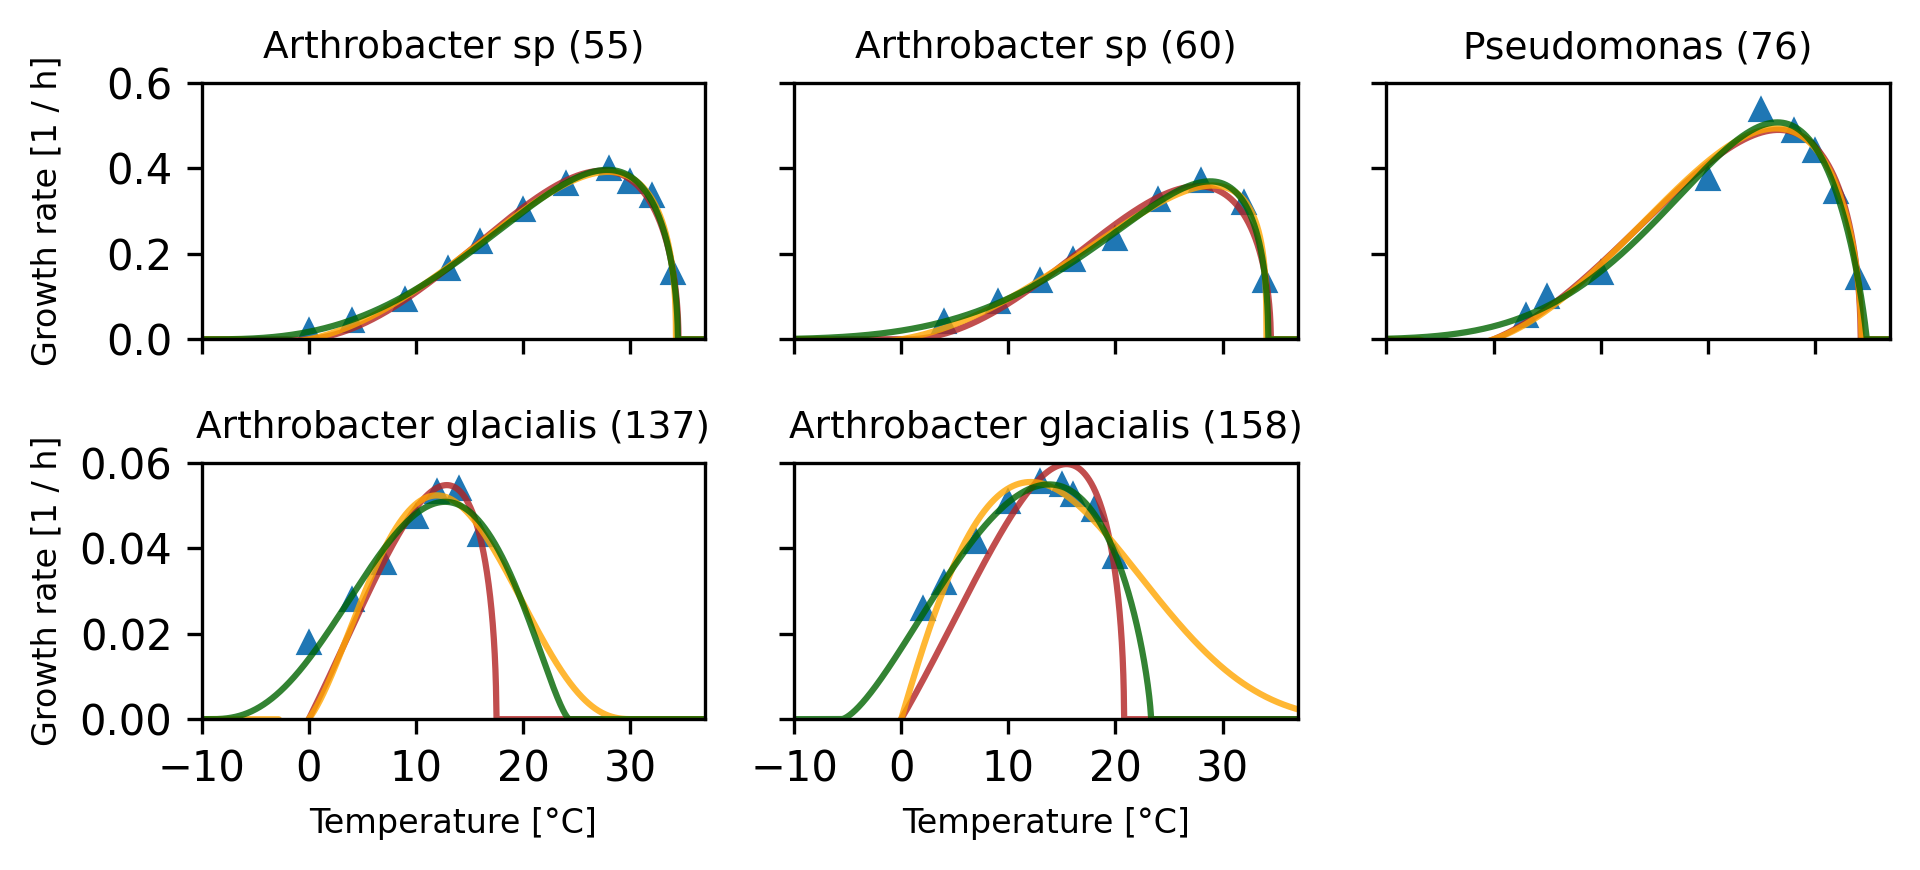

In [26]:
T = np.arange(-10, 40, 0.001)

fig, axarr = plt.subplots(2, 3, figsize=(6.5, 3), dpi=300, sharex=True, sharey='row')


for i, s in enumerate(strains):
    ax = axarr[i // 3, i % 3]

    subset = glacierbac[glacierbac["strain"] == s]
    species = list(subset["species"])[0]
    
    # Plot datapoints.
    Tdata = subset["T"]
    rdata = subset["r"]

    ax.plot(Tdata, rdata, '^', markersize=5)
    ax.set_xticks([-10, 0, 10, 20, 30])
    
    ax.set_xlim(-10, 37)
    
    if s in (55, 60, 76):
        #ax.set_ylim(0, round(max(rdata)*1.2, 1) )
        #ax.set_yticks(fontsize=5)
        ax.set_ylim(0, 0.6)
    else:
        ax.set_ylim(0, 0.06)
        #ax.set_ylim(0, round(max(rdata)*1.1, 2) )
    
    # Plot fitted curves by Briere.
    par = params["b1"][s]["x"]
    ax.plot(T, briere1(T, *par[:-1]), color="firebrick", alpha=0.8)
    
    par = params["b2"][s]["x"]
    ax.plot(T, briere2(T, *par[:-1]), color="orange", alpha=0.8)
    
    #par = params["rmb3"][s]["x"]
    #plt.plot(T, rmodbriere_3(T, *par[:-1]), color="blue", alpha=0.7)
    
    #par = params["rmb4"][s]["x"]
    #plt.plot(T, rmodbriere_4(T, *par[:-1]), color="gray", alpha=0.7)
             
    par = params["flexTPC"][s]["x"]
    ax.plot(T, flexTPC(T, *par[:-1]), color="darkgreen", alpha=0.8)
    

    
    ax.set_title(species + " (" + str(s) + ")", fontsize=9)

    if s in (137, 158):
        ax.set_xlabel("Temperature [°C]", fontsize=8)
    if s in (55, 137):
        ax.set_ylabel(r"Growth rate [1 / h]", fontsize=8)

axarr[-1, -1].axis("off")

plt.tight_layout()
fig.align_labels()
plt.savefig("glacierbac.pdf")
plt.savefig("glacierbac.png")
plt.savefig("glacierbac.svg")


In [17]:
species_list = ['Arthrobacter sp', 'Arthrobacter sp', 'Pseudomonas', 'Arthrobacter glacialis', 'Arthrobacter glacialis']
n_params = {'b1':4, 'b2':5, 'flexTPC':6} # Includes standard deviation.
param_matrix = {model:np.zeros((5, n_params[model])) for model in models}

for model in models:
    for i, strain in enumerate(strains):
        param_matrix[model][i, ] = params[model][strain]["x"]

colnames = {'b1':['Tmin', 'Tmax', 'c', 'sigma2'],
            'b2':['Tmin', 'Tmax', 'c', 'm', 'sigma2'],
            'flexTPC':['Tmin', 'Tmax', 'rmax', 'alpha', 'beta', 'sigma2']}

param_df = {model:pd.DataFrame(param_matrix[model], columns=colnames[model]) for model in models}

for model in models:
    param_df[model]['strain'] = strains
    param_df[model]['species'] = species_list
    param_df[model] = param_df[model][['species', 'strain'] + colnames[model]]
    param_df[model].to_csv(f'glacierbac_params_{model}.csv', index=False)

In [18]:
param_df['flexTPC']

,species,strain,Tmin,Tmax,rmax,alpha,beta,sigma2
0,Arthrobacter sp,55,-9.777811,34.456556,0.396684,0.851142,0.191401,4.330609e-05
1,Arthrobacter sp,60,-19.999030,34.263106,0.369805,0.900109,0.138623,3.382453e-05
2,Pseudomonas,76,-19.999933,34.822869,0.507802,0.848116,0.151044,3.272288e-04
3,Arthrobacter glacialis,137,-9.353280,24.330746,0.050876,0.655434,0.232482,7.856058e-06
4,Arthrobacter glacialis,158,-5.551258,23.326786,0.054946,0.670261,0.315771,6.822184e-07


In [19]:
species_list = list(set(glacierbac["species"]))

In [20]:
nll = np.zeros((len(strains), len(models)))
loo_nll = np.zeros((len(strains), len(models)))
aic = np.zeros((len(strains), len(models)))
bic = np.zeros((len(strains), len(models)))
p = [4, 5, 6] # Number of parameters

for i, s in enumerate(strains):
    n = len(glacierbac[glacierbac["strain"] == s]) # Number of datapoints.

    for j, m in enumerate(models): 
        nll[i, j] = params[m][s]["fun"]
        loo_nll[i, j] = np.mean(loocv_nll[m][s])
        aic[i, j] = AIC(nll[i, j], p[j])
        bic[i, j] = BIC(nll[i, j], n, p[j])

In [21]:
len(glacierbac)

45

In [22]:
dfAIC = pd.DataFrame(np.round(aic, 2), columns=models, index=strains)
dfBIC = pd.DataFrame(np.round(bic, 2), columns=models, index=strains)
dfLOOCV = pd.DataFrame(np.round(loo_nll, 2), columns=models, index=strains)

In [23]:
dfAIC

,b1,b2,flexTPC
55,-60.66,-63.68,-67.31
60,-37.43,-46.32,-55.13
76,-31.86,-30.17,-34.69
137,-41.18,-38.82,-50.41
158,-52.02,-64.14,-90.24


In [24]:
dfBIC

,b1,b2,flexTPC
55,-59.07,-61.69,-64.92
60,-36.64,-45.33,-53.94
76,-31.07,-29.19,-33.51
137,-41.40,-39.09,-50.74
158,-51.24,-63.15,-89.06


In [25]:
dfLOOCV

,b1,b2,flexTPC
55,0.27,-3.35,-3.61
60,2.53,-3.13,-3.73
76,inf,-2.23,-2.59
137,-1.32,-3.49,-4.46
158,inf,-4.12,-5.68
